# Detectron2 Data Preperation

When using a Mask R-CNN Model from Detectron2 it expects data in the COCO Format. This notebook will supply all of the tools you might need to format the Sartorius Cell Instance Segmentation competition data into this format.

## Table of Contents:
1. Imports
2. Reading Competition Data
3. Splitting Data into K-Folds
4. Coco Format given Pandas DataFrame and Image Data Location.


### Imports

In [1]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import random
import json
import time
import sys
import cv2
import os

from pycocotools import mask as mask_utils
from joblib import Parallel, delayed

### Dealing with Competition Data

We are given PNG images and a CSV File containing RLE Encoded Masks of each image. I am going to assume knowledge of RLE Encoding (if not just google it).

Below I have supplied to functions to decode and encode RLE Encodings for instance masks. 

In [2]:
def rle_decode(rle_list, shape = (520, 704), arr_type = np.uint16):
    """
    Given a list of RLE encoded masks, decode them and
    return the numpy int64 mask.

    Args:
        rle_list (list): List of RLE encoded masks for
        a whole image.

        shape (tuple): Tuple shape of the final image.
        
    Returns:
        np.array (np.uint16)

    """
    mask = np.zeros((shape[0] * shape[1], 1), dtype = np.uint64)

    for idx, rle in enumerate(rle_list, 1):
        rle    = rle.split()
        np_rle = np.array(rle, dtype = np.uint64)

        first_indices = np_rle[0 : : 2] - 1 
        lengths       = np_rle[1 : : 2]
        last_indices  = first_indices + lengths 

        for i in range(len(first_indices)):
            mask[first_indices[i] : last_indices[i]] = idx

    return mask.reshape(shape).astype(arr_type)

def single_rle_decode(rle_str, shape = (520, 704), arr_type = np.uint16):
    """
    Decodes single instance RLE Encoding.

    Args:
        rle_str (String): String containing RLE Encoding for a single
        instance. 

        shape (tuple): Tuple shape of the final image.
        
    Returns:
        np.array (np.uint16)

    """
    np_rle = np.array(rle_str.split(), dtype = np.uint64)

    starts  = np_rle[0 :: 2] - 1
    lengths = np_rle[1 :: 2]
    ends = starts + lengths 

    mask = np.zeros((shape[0] * shape[1], 1), dtype = np.uint8)
    for i in range(len(starts)):
        mask[starts[i] : ends[i]] = 1 

    mask = mask.reshape(shape)

    return mask


def rle_encode(mask_instance):
    """
    Given a single instance of a mask, return the RLE
    encoding of that instance. Will need to be run for
    every instance you may have in your mask.

    Args:
        mask_instance (np.array): A single instance in 
        your mask that needs to be RLE encoded.

    Returns:
        string: The RLE encoding in string form of the mask
        instance

    """
    flattened = mask_instance.flatten()

    shift = np.concatenate([[0], flattened, [0]])

    runs = np.flatnonzero(shift[1:] != shift[:-1]) + 1

    runs[1 : : 2] -= runs[ : : 2]

    return " ".join(str(run) for run in runs)


Now that we have functions to decode and encode RLE Encoded Instance Masks lets load up the train.csv file and plot a couple of these masks to make sure it works.


In [3]:
data_dir = "../../data/"

In [4]:
df = pd.read_csv(os.path.join(data_dir, "train.csv"))
df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


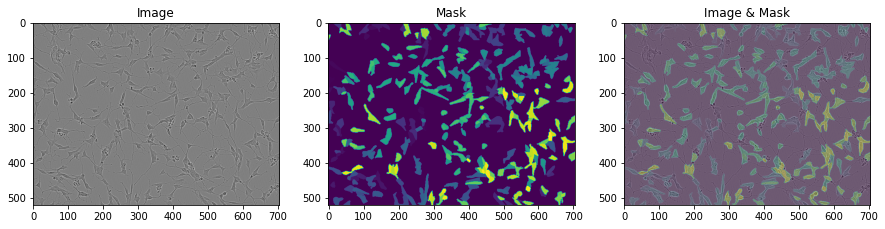

In [5]:
unique_ids = df["id"].unique().tolist()

random_id  = "48a750fc02a2"

df_id      = df[df["id"] == random_id]

np_mask    = rle_decode(df_id["annotation"].tolist())

png_image  = cv2.imread(os.path.join(data_dir, f"train/{random_id}.png"))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 15))

ax1.set_title("Image")
ax1.imshow(png_image)

ax2.set_title("Mask")
ax2.imshow(np_mask)

ax3.set_title("Image & Mask")
ax3.imshow(png_image)
ax3.imshow(np_mask, alpha = 0.3)

plt.show()

### K-Fold Split

So now that we know our functions work lets explore how one would go about getting a K-Fold Split of the DF.

In [6]:
############################################################
# The following code is modified from a Kaggle Notebook that 
# was written by "AMMAR ALHAJ ALI" and can be found 
# here: 
# https://www.kaggle.com/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator
############################################################

def k_fold_sartorius(df, k_fold = 5):
    """
    Args:
        df (Pandas DataFrame): The "train.csv" file given in
        the Kaggle Sartorius Cell Instance Segmenation in a 
        Pandas DataFrame.
        
        k_fold (int): Number of Folds / Splits you want your
        DataFrame in.
        
    Returns:
        List: List of "k_fold" Pandas DataFrames.
        
    """
    df_meta = df.drop_duplicates(subset = "id")[["id", "cell_type"]]
    df_meta = df_meta.reset_index()
    
    skf = StratifiedKFold(n_splits = k_fold, shuffle = True)
    for fold, (_, val_idx) in enumerate(skf.split(X = df_meta, y = df_meta["cell_type"]), 1):
        df_meta.loc[val_idx, "fold"] = fold
        
    folds = []
    for i in range(1, k_fold + 1):
        ids = df_meta[df_meta["fold"] == i]["id"]
        
        folds.append(
            df[df["id"].isin(ids)].reset_index()
        )
        
    return folds


In [7]:
folds = k_fold_sartorius(df, k_fold = 5)

# Set equal to true if you want to visualize
# number of classes in each fold.
verbose = False

for k, fold in enumerate(folds, 1):
    unique_fold_ids = fold["id"].unique().tolist()
    for id in unique_fold_ids:
        mask0 = rle_decode(df[df["id"] == id]["annotation"].tolist()).astype(np.uint16)
        mask1 = rle_decode(fold[fold["id"] == id]["annotation"].tolist()).astype(np.uint16)
        
        # Make sure that the masks are the same in both our 
        # Fold DataFrames and Control DataFrame.
        assert np.array_equal(mask0, mask1)
        
    if verbose or k <= 2: 
        fold_info = fold.groupby(["id", "cell_type"])["cell_type"].first().value_counts()
        print(fold_info)
        print("=============================")


cort      64
shsy5y    31
astro     27
Name: cell_type, dtype: int64
cort      64
shsy5y    31
astro     26
Name: cell_type, dtype: int64


### COCO Format

Now that we have visualized the masks and split out Pandas DataFrame it's time
to format our dataframes into COCO Format so we can train and evaluate using the
Detectron2 library.

In [8]:
def sartorius_coco_formater(df, class_idx, workers = 4):
    """
    This is the main COCO formating function.

    Args:
        df (Pandas DataFrame): Pandas DataFrame of the 
        Sartorius train.csv. 
        
        class_idx (Dictionary): Dictionary containing each class name
        and it's corresponding index. Examples below.
        
        workers (int): Number of cpu's in current machine.

    Returns:
        dict: COCO formated dictionary of the sartorius "train.csv"
              df ready to be written to memory as a JSON file.

    """

    COCO_CLASSES = []
    for CLASS in class_idx:
        COCO_CLASSES.append({
            "name" : CLASS,
            "id"   : class_idx[CLASS]
        })


    images = []
    for ID in df.id.unique():
        images.append({
            "id"        : ID,
            "width"     : 704,
            "height"    : 520,
            "file_name" : f"train/{ID}.png"
        })


    parallel = Parallel(n_jobs = workers)
    annotate = delayed(annotater)
    annotations = parallel(annotate(class_idx, idx, row) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories': COCO_CLASSES, 'images': images, 'annotations': annotations}


def annotater(class_idx, idx, row):
    mask = single_rle_decode(row.annotation, (row.height, row.width))
    mask = np.asfortranarray(mask)

    coco_rle = mask_utils.encode(mask)
    coco_rle["counts"] = coco_rle["counts"].decode("utf-8")

    area = mask_utils.area(coco_rle).item() 

    bbox = mask_utils.toBbox(coco_rle).astype(int).tolist() 

    annotation = {
        "segmentation" : coco_rle,
        "bbox"         : bbox,
        "area"         : area,
        "image_id"     : row.id,
        "category_id"  : class_idx[row.cell_type],
        "iscrowd"      : 0, 
        "id"           : idx
    }

    return annotation

In [9]:
#test_fold = folds[0].reset_index()

class_idx = {
    "shsy5y" : 1, 
    "astro"  : 2, 
    "cort"   : 3
}

train_jsons = []
test_jsons  = []

for i, fold in enumerate(folds):
    train_frames = [df_f for j, df_f in enumerate(folds) if j != i]
    test_frames  = fold.reset_index()

    train_frames = pd.concat(train_frames).reset_index()
    
    train_coco_dict = sartorius_coco_formater(train_frames, class_idx, workers = 4)
    test_coco_dict  = sartorius_coco_formater(test_frames,  class_idx, workers = 4)
    
    train_jsons.append(train_coco_dict)
    test_jsons.append(test_coco_dict)

  0%|          | 0/58326 [00:00<?, ?it/s]

  0%|          | 0/15259 [00:00<?, ?it/s]

  0%|          | 0/59837 [00:00<?, ?it/s]

  0%|          | 0/13748 [00:00<?, ?it/s]

  0%|          | 0/59360 [00:00<?, ?it/s]

  0%|          | 0/14225 [00:00<?, ?it/s]

  0%|          | 0/58308 [00:00<?, ?it/s]

  0%|          | 0/15277 [00:00<?, ?it/s]

  0%|          | 0/58509 [00:00<?, ?it/s]

  0%|          | 0/15076 [00:00<?, ?it/s]

Then convert it a json file:

In [10]:
os.makedirs("./coco_formated", exist_ok = True)

for i, (train_f, test_f) in enumerate(zip(train_jsons, test_jsons)):
    train_json_dir = f"./coco_formated/fold_{i}_train.json"
    test_json_dir  = f"./coco_formated/fold_{i}_test.json"

    with open(train_json_dir, "w") as ex_file:
        json.dump(train_f, ex_file, ensure_ascii = True, indent = 4)
    
    with open(test_json_dir, "w") as ex_file:
        json.dump(test_f,  ex_file, ensure_ascii = True, indent = 4)
        

<br />

**Author:** Ryan Peters

**License:** MIT